### Predict El Nino Southern Oscillation with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict sea-surface temperature (SST) anomalies related to El Nino Southern Oscillation (ENSO). Several SST anomaly indices are included in CICMoD dataset, area-averaged over different regions of Tropical Pacific. Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various lead times (0, 1, 2, 3, 6 months) as **target** to predict on various time horizons: Current phase (lead time 0) and 1, 2, 3, 6 months into the future. The remaining indices included in CICMoD serve as **input** time series. 

**Note:** For detecting the current and future ENSO phase, we won't use the other ENSO indices as inputs, due to expected high correlation to our target. 

**Outline in this experiment:**
- Create **target indices** with different lead times from ENSO34.
- Check how remaining input time series **correlate** to target indices.
- Train **CNN/fc** model.
- Compare with **LSTM/fc** model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence
from cicmod_application.events import consecutive_masking, el_nino, la_nina

from numpy.testing import assert_allclose, assert_almost_equal

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.12.15.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index:
climind = climind.set_index(["model","year","month","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model year month                                                               
CESM  1    1     -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
           2     -0.055288  0.871110  1.725915  1.881192  1.460391  0.628604   
           3      0.000295  0.641493  1.292365  1.510816  1.266292  1.332836   
           4      0.017316  0.373644  0.930377  1.034762  0.775709  0.226980   
           5      0.031327 -0.038862  0.335949  0.702846  0.743190  0.995570   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8      0.178689  0.522490  1.009402  1.137735  1.011215  0.906418   
           9      0.098525  0.310882  0.931236  1.269963  1.355198  0.669222   
           10     0.012815  0.201341  0.842481  1.186615  1.407205  0.515824   
           11    -0.028865  0.250733  0.882067  1.289584  1.747254 -0.928136   
           12    -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model year month                                            ...             
CESM  1    1      1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
           2      1.635490 -0.794662  0.391417   -0.002575  ...  0.088257   
           3      0.489595 -1.425871  0.566098   -0.095461  ...  0.121279   
           4      0.473761 -0.272417  0.879974   -0.121519  ...  0.204674   
           5      2.401551 -0.381626  1.086773    0.400654  ... -0.174217   
...                    ...       ...       ...         ...  ...       ...   
FOCI  1000 8      1.207901 -0.204993 -0.748606    0.684613  ... -0.903461   
           9      1.404237  0.132056 -0.420135    0.739803  ... -1.069282   
           10     1.190851 -0.353718 -0.232508   -0.029205  ... -1.003289   
           11    -1.419175  1.089200 -0.381073   -0.004869  ... -0.674776   
           12    -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model year month                                                               
CESM  1    1      0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
           2      0.084034 -0.552023 -0.027617  0.602004  0.141540  0.036850   
           3      0.091827 -0.383901 -0.117263  0.359004  0.199297 -0.004955   
           4      0.097583 -0.218266 -0.047506  0.066606  0.152572 -0.107935   
           5     -0.365616 -0.188526 -0.354763  0.090692  0.205236 -0.138338   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8     -0.571605 -0.096008  0.587311 -0.194002  0.054469  0.091777   
           9     -0.607013 -0.043860  0.796168 -0.228907  0.053131  0.274988   
           10    -0.415460  0.055235  0.992450  0.001155 -0.029871  0.225920   
           11    -0.078932  0.135558  0.973861  0.029547 -0.074635  0.077247   
           12    -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model year month                                
CESM  1    1      0.038024  0.526206 -0.316788  
           2      0.070549  0.416427 -0.276104  
           3      0.160956  0.378252 -0.186131  
           4      0.023744  0.319001 -0.130724  
           5     -0.041518  0.126895 -0.144448  
...                    ...       ...       ...  
FOCI  1000 8      0.026577  0.050525  0.123432  
           9      0.030738 -0.008511  0.028916  
           10    -0.087775 -0.100116  0.055975  
           11    -0.167492 -0.162180  0.172732  
           12    -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Prepare inputs and targets

Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various lead times (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series.

In [3]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Optionally exclude ENSO indices to form input features:
input_FOCI = climind_FOCI.loc[:, ["ENSO" not in col for col in climind_FOCI.columns]]
input_CESM = climind_CESM.loc[:, ["ENSO" not in col for col in climind_CESM.columns]]

# Extract ENSO_34 index:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'ENSO_34']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'ENSO_34']

# Create targets with lead time 1, 2, 3, 6 months:
target_FOCI_lead1 = target_FOCI['ENSO_34'][1:-5].values
target_FOCI_lead2 = target_FOCI['ENSO_34'][2:-4].values
target_FOCI_lead3 = target_FOCI['ENSO_34'][3:-3].values
target_FOCI_lead6 = target_FOCI['ENSO_34'][6:].values
target_CESM_lead1 = target_CESM['ENSO_34'][1:-5].values
target_CESM_lead2 = target_CESM['ENSO_34'][2:-4].values
target_CESM_lead3 = target_CESM['ENSO_34'][3:-3].values
target_CESM_lead6 = target_CESM['ENSO_34'][6:].values

# Erase last 6 rows from inputs and target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]

# Add targets with individual lead times as new columns:
target_FOCI['ENSO_34_lead1'] = target_FOCI_lead1
target_FOCI['ENSO_34_lead2'] = target_FOCI_lead2
target_FOCI['ENSO_34_lead3'] = target_FOCI_lead3
target_FOCI['ENSO_34_lead6'] = target_FOCI_lead6
target_CESM['ENSO_34_lead1'] = target_CESM_lead1
target_CESM['ENSO_34_lead2'] = target_CESM_lead2
target_CESM['ENSO_34_lead3'] = target_CESM_lead3
target_CESM['ENSO_34_lead6'] = target_CESM_lead6

# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_FOCI.shape)
print("CESM inputs shape (time steps, features): ", input_CESM.shape)
print("\nFOCI target shape (time steps, features): ", target_FOCI.shape)
print("CESM target shape (time steps, features): ", target_CESM.shape)

FOCI inputs shape (time steps, features):  (11994, 25)
CESM inputs shape (time steps, features):  (11982, 25)

FOCI target shape (time steps, features):  (11994, 5)
CESM target shape (time steps, features):  (11982, 5)


### Check correlation

Next we check, how remaining input features correlate to targets with different lead times.

<AxesSubplot:title={'center':'Pairwise correlation of input features and target series with different lead times (FOCI)'}, xlabel='index', ylabel='index'>

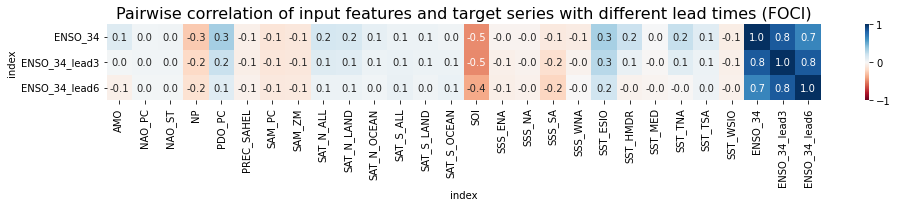

In [11]:
# Plot correlation of inputs and target series as heatmap:
fig, ax = plt.subplots(figsize=(16,1.4))
plt.title('Pairwise correlation of input features and target series with different lead times (FOCI)', fontsize=16)
sns.heatmap(
    pd.concat([input_FOCI, target_FOCI[['ENSO_34', 'ENSO_34_lead3', 'ENSO_34_lead6']]], axis=1).corr()[-3:], 
    cmap="RdBu",
    xticklabels=True, 
    yticklabels=True,
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".1f",
)

### Discussion on correlation check

Find inputs and targets to be **mostly un-correlated**. If at all, we see some minor correlation between PC-based Pacific Decadal Oscillation (PDO_PC) or Eastern Subtropical Indian Ocean sea-surface temperature anomaly (SST_ESIO) and ENSO3.4 index (ENSO_34). Correlation coefficient reads 0.34 and 0.33, respectively.

### Continue data pre-processing

We now continue to prepare inputs and targets:

- Split sequences into samples of specified input length.
- Split inputs and targets into train and validation sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [4]:
## Set parameters for inputs and target:

# Select input features:
input_features = [
    'AMO', 'NAO_PC', 'NAO_ST', 'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI', 'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA',
    'SST_ESIO', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# Specify input length:
input_length = 24  # months

# Specify relative amount of train data:
train_val_split = 0.8

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_01' #'norm' #'scale_01'

In [5]:
# Select specified input features:
inputs_selected_FOCI = input_FOCI[input_features]
inputs_selected_CESM = input_CESM[input_features]

# Split input values into sequences of specified input length:
inputs_split_FOCI = split_sequence(inputs_selected_FOCI, input_length)
inputs_split_CESM = split_sequence(inputs_selected_CESM, input_length)

# Adjust targets: Cut first (input_length - 1) entries:
target_cut_FOCI = target_FOCI[input_length-1:]
target_cut_CESM = target_CESM[input_length-1:]

In [6]:
## Split inputs and targets into train and validation sets:

# Get number of train samples:
n_train = int(train_val_split * len(inputs_split_FOCI))

# Split inputs and targets:
train_input_FOCI = inputs_split_FOCI[:n_train]
train_input_CESM = inputs_split_CESM[:n_train]
val_input_FOCI = inputs_split_FOCI[n_train:]
val_input_CESM = inputs_split_CESM[n_train:]

train_target_FOCI = target_cut_FOCI[:n_train]
train_target_CESM = target_cut_CESM[:n_train]
val_target_FOCI = target_cut_FOCI[n_train:]
val_target_CESM = target_cut_CESM[n_train:]

# Check dimensions:
print("FOCI: train_input shape (samples, time steps, features): ", train_input_FOCI.shape)
print("FOCI_val_input shape (samples, time steps, features): ", val_input_FOCI.shape)
print("CESM: train_input shape (samples, time steps, features): ", train_input_CESM.shape)
print("CESM_val_input shape (samples, time steps, features): ", val_input_CESM.shape)
print("\nFOCI: train_target shape (samples, features): ", train_target_FOCI.shape)
print("FOCI: val_target shape (samples, features): ", val_target_FOCI.shape)
print("CESM train_target shape (samples, features): ", train_target_CESM.shape)
print("CESM: val_target shape (samples, features): ", val_target_CESM.shape)

FOCI: train_input shape (samples, time steps, features):  (9576, 24, 25)
FOCI_val_input shape (samples, time steps, features):  (2395, 24, 25)
CESM: train_input shape (samples, time steps, features):  (9576, 24, 25)
CESM_val_input shape (samples, time steps, features):  (2383, 24, 25)

FOCI: train_target shape (samples, features):  (9576, 5)
FOCI: val_target shape (samples, features):  (2395, 5)
CESM train_target shape (samples, features):  (9576, 5)
CESM: val_target shape (samples, features):  (2383, 5)


In [15]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
train_mean_FOCI = np.mean(train_input_FOCI, axis=(0,1))
train_std_FOCI = np.std(train_input_FOCI, axis=(0,1))
train_min_FOCI = np.min(train_input_FOCI, axis=(0,1))
train_max_FOCI = np.max(train_input_FOCI, axis=(0,1))
train_mean_CESM = np.mean(train_input_CESM, axis=(0,1))
train_std_CESM = np.std(train_input_CESM, axis=(0,1))
train_min_CESM = np.min(train_input_CESM, axis=(0,1))
train_max_CESM = np.max(train_input_CESM, axis=(0,1))

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    val_input_scaled_FOCI = (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    train_input_scaled_CESM = (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)
    val_input_scaled_CESM = (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = 2 * (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    val_input_scaled_FOCI = 2 * (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1 
    train_input_scaled_CESM = 2 * (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    val_input_scaled_CESM = 2 * (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (train_input_FOCI - train_mean_FOCI) / train_std_FOCI
    val_input_scaled_FOCI = (val_input_FOCI - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (train_input_CESM - train_mean_CESM) / train_std_CESM
    val_input_scaled_CESM = (val_input_CESM - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print("FOCI: train_input MIN: ", np.round(np.min(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MAX: ", np.round(np.max(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MEAN: ", np.round(np.mean(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input STD: ", np.round(np.std(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MIN: ", np.round(np.min(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MAX: ", np.round(np.max(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MEAN: ", np.round(np.mean(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input STD: ", np.round(np.std(val_input_scaled_FOCI, axis=(0,1)), 2))
print("\n\nCESM: train_input MIN: ", np.round(np.min(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MAX: ", np.round(np.max(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MEAN: ", np.round(np.mean(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input STD: ", np.round(np.std(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MIN: ", np.round(np.min(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MAX: ", np.round(np.max(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MEAN: ", np.round(np.mean(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input STD: ", np.round(np.std(val_input_scaled_CESM, axis=(0,1)), 2))

FOCI: train_input MIN:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
FOCI: train_input MAX:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
FOCI: train_input MEAN:  [0.45 0.44 0.47 0.5  0.5  0.3  0.57 0.57 0.5  0.54 0.5  0.55 0.48 0.56
 0.47 0.48 0.46 0.57 0.48 0.5  0.51 0.49 0.51 0.51]
FOCI: train_input STD:  [0.13 0.12 0.12 0.12 0.13 0.06 0.14 0.15 0.11 0.12 0.12 0.12 0.11 0.12
 0.14 0.14 0.12 0.14 0.13 0.13 0.11 0.13 0.12 0.12]
FOCI: val_input MIN:  [ 0.03  0.08  0.08  0.02  0.12  0.06 -0.07 -0.06  0.11  0.1   0.04  0.12
  0.09  0.09  0.07  0.01  0.03  0.06  0.02  0.1   0.08 -0.01  0.12  0.09]
FOCI: val_input MAX:  [0.97 0.89 0.94 0.93 0.92 0.78 0.99 0.97 0.99 1.06 0.93 0.9  0.95 0.93
 0.96 0.93 0.92 0.93 0.95 1.   1.02 0.91 0.92 0.99]
FOCI: val_input MEAN:  [0.5  0.44 0.47 0.49 0.49 0.3  0.57 0.58 0.51 0.55 0.52 0.58 0.49 0.59
 0.5  0.5  0.48 0.51 0.49 0.52 0.53 0.51 0.52 0.54]
FOCI: val_input STD:  [0.13 0.12 0.13 0.12 0.13 0

### Define functions for CNN/fc, LSTM/fc and CNN/LSTM models

We are going to apply different ANN model architectures. For convenience, define model architectures in a functional form:
- CNN / fc model
- LSTM / fc model

**CNN / fc** model:
The model is based on a number of CNN layers. For each CNN layer the number of filters (CNN_filters) and the filter size (CNN_kernel_size) used in the convolution needs to be specified. Each CNN layer consists of the 1D convolution itself, followed by batch normalization and ReLU activation. Note: If input length is larger or equal to 20 time steps, we add max pooling (with pool_size=2) after each CNN layer, to limit the number of trainable parameters and prevent the model from overfitting. The final CNN layer's output is then flattened and used as input for the fully connected (fc) Dense layers, stacked on top of the CNN layers. Again, the number of fc layers and the number of units per layer need to be specified (both in fc_units) and the hidden activation can be chosen.

**LSTM / fc** model:
The model is based on a number of LSTM layers. For each LSTM layer the number units needs to be specified. The final LSTM layer's output is then used as input for the fully connected (fc) Dense layers, stacked on top of the LSTM layers. Again, the number of fc layers and the number of units per layer need to be specified (both in fc_units) and the hidden activation can be chosen.

In [16]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 20:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
   
    return model

In [10]:
def set_LSTM_fc(LSTM_units, fc_units, fc_hidden_activation,
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up LSTM/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
  
    # Add LSTM layer(s):
    for i in range(len(LSTM_units)):
        
        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=True))
        else:
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=False))
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
   
    return model

### CNN / fc: Define model parameters and start single-run experiment on ALL target horizons

**Note:** Scale inputs to [0,1] in data pre-processing!

In [17]:
# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'linear'
n_epochs = 20
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

In [18]:
## Set up compiled CNN/fc models separately for both - FOCI and CESM, and ALL target horizons:

# Initialize storages for models:
models_CNNfc_FOCI = []
models_CNNfc_CESM = []

# Set model for ALL target horizons:
for i in range(len(target_FOCI.columns)):
    temp_model_FOCI = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                                 n_epochs, batch_size, learning_rate, loss_function)
    temp_model_CESM = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                                 n_epochs, batch_size, learning_rate, loss_function)
    # Store models:
    models_CNNfc_FOCI.append(temp_model_FOCI)
    models_CNNfc_CESM.append(temp_model_CESM)    

# Show model summary for one model, as example:
models_CNNfc_FOCI[0].summary()
#plot_model(models_CNNfc_FOCI[0], show_shapes=True, show_layer_names=True)

2022-12-14 17:33:34.481700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 10)            1210      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 10)            40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20, 10)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 20)             1020      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 20)             80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 20)             0

In [19]:
## Train all models and store histories:

# Initialize storages for histories:
histories_CNNfc_FOCI = []
histories_CNNfc_CESM = []

# FOCI models:
for i in range(len(models_CNNfc_FOCI)):
    
    # Print status:
    print("FOCI model:", i+1, "of", len(models_CNNfc_FOCI))
    temp_history = models_CNNfc_FOCI[i].fit(train_input_scaled_FOCI, train_target_FOCI.iloc[:,[i]].values,
                                            epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=0,
                                            validation_data=(
                                                val_input_scaled_FOCI,
                                                val_target_FOCI.iloc[:,[i]].values
                                            ))
    
    # Store history:
    histories_CNNfc_FOCI.append(temp_history)
    
# CESM models:
for i in range(len(models_CNNfc_CESM)):
    
    # Print status:
    print("CESM model:", i+1, "of", len(models_CNNfc_CESM))
    temp_history = models_CNNfc_CESM[i].fit(train_input_scaled_CESM, train_target_CESM.iloc[:,[i]].values,
                                            epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=0,
                                            validation_data=(
                                                val_input_scaled_CESM,
                                                val_target_CESM.iloc[:,[i]].values
                                                 ))
    
    # Store history:
    histories_CNNfc_CESM.append(temp_history)

FOCI model: 1 of 5


2022-12-14 17:33:46.737956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


FOCI model: 2 of 5
FOCI model: 3 of 5
FOCI model: 4 of 5
FOCI model: 5 of 5
CESM model: 1 of 5
CESM model: 2 of 5
CESM model: 3 of 5
CESM model: 4 of 5
CESM model: 5 of 5


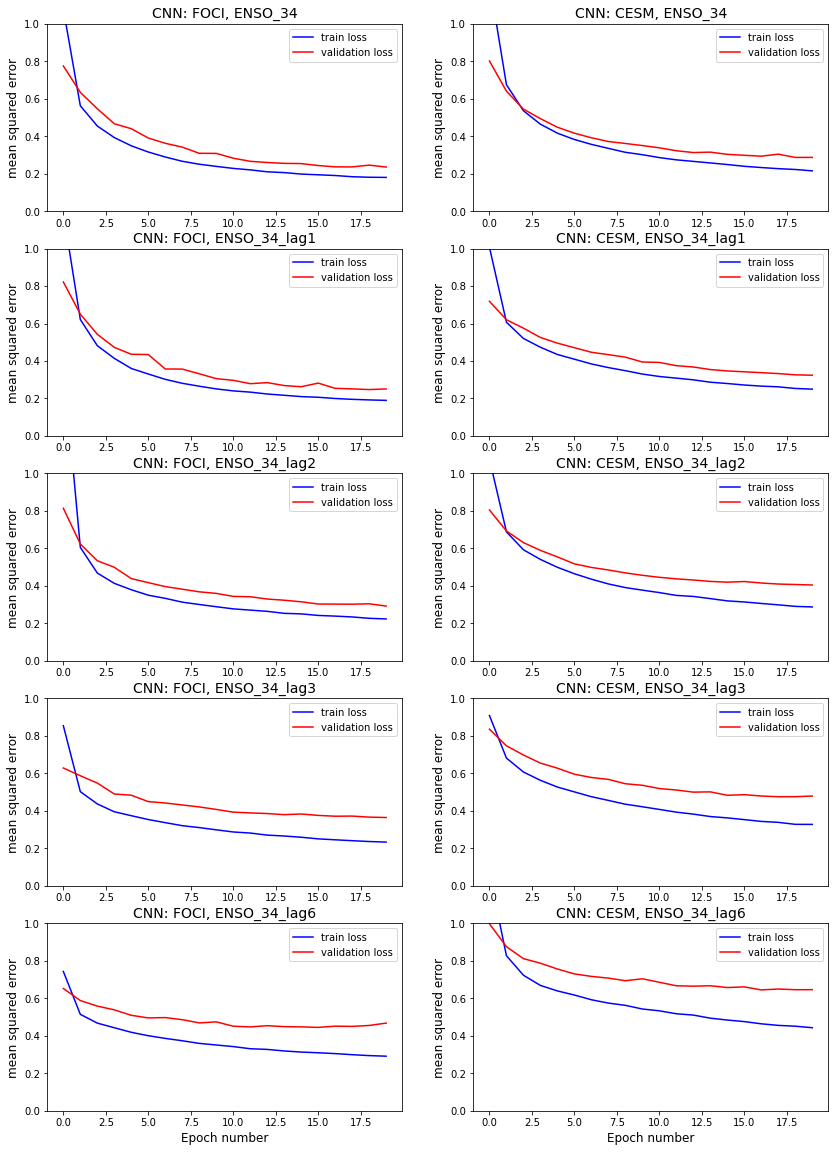

In [228]:
# Plot train and val_loss (mse), for both models and ALL target horizons:
fig, axes = plt.subplots(5, 2, figsize=(14,20))

# Loop over target horizons:
for i in range(len(histories_CNNfc_FOCI)):

    # FOCI
    axes[i,0].plot(histories_CNNfc_FOCI[i].history['loss'], color = 'blue', label = 'train loss')
    axes[i,0].plot(histories_CNNfc_FOCI[i].history['val_loss'], color = 'red', label = 'validation loss')
    axes[i,0].set_ylabel('mean squared error', fontsize=12)
    axes[i,0].set_ylim([0,1])
    axes[i,0].set_title('CNN: FOCI, '+target_FOCI.columns[i], fontsize=14)
    axes[i,0].legend()

    # CESM
    axes[i,1].plot(histories_CNNfc_CESM[i].history['loss'], color = 'blue', label = 'train loss')
    axes[i,1].plot(histories_CNNfc_CESM[i].history['val_loss'], color = 'red', label = 'validation loss')
    axes[i,1].set_ylabel('mean squared error', fontsize=12)
    axes[i,1].set_ylim([0,1])
    axes[i,1].set_title('CNN: CESM, '+target_CESM.columns[i], fontsize=14)
    axes[i,1].legend()

axes[len(histories_CNNfc_FOCI)-1,0].set_xlabel('Epoch number', fontsize=12)
axes[len(histories_CNNfc_FOCI)-1,1].set_xlabel('Epoch number', fontsize=12)

plt.show()

In [9]:
## Save and re-load trained CNN/fc models:


# ## Saved models for CNN experiments on FOCI and CESM inputs and ENSO3.4 as target with various lead times.
# models_CNNfc_FOCI[0].save('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead0')
# models_CNNfc_FOCI[1].save('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead1')
# models_CNNfc_FOCI[2].save('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead2')
# models_CNNfc_FOCI[3].save('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead3')
# models_CNNfc_FOCI[4].save('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead6')
# models_CNNfc_CESM[0].save('../models/CNN_final/models_CNNfc_CESM_ENSO_lead0')
# models_CNNfc_CESM[1].save('../models/CNN_final/models_CNNfc_CESM_ENSO_lead1')
# models_CNNfc_CESM[2].save('../models/CNN_final/models_CNNfc_CESM_ENSO_lead2')
# models_CNNfc_CESM[3].save('../models/CNN_final/models_CNNfc_CESM_ENSO_lead3')
# models_CNNfc_CESM[4].save('../models/CNN_final/models_CNNfc_CESM_ENSO_lead6')


# ## Reload trained CNN models:

# !!!!! Scaled inputs to [0,1] in data pre-processing !!!!!

# # Initialize storages for models:
# models_CNNfc_FOCI = []
# models_CNNfc_CESM = []

# models_CNNfc_FOCI_ENSO_lead0 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead0')
# models_CNNfc_FOCI_ENSO_lead1 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead1')
# models_CNNfc_FOCI_ENSO_lead2 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead2')
# models_CNNfc_FOCI_ENSO_lead3 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead3')
# models_CNNfc_FOCI_ENSO_lead6 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_FOCI_ENSO_lead6')

# models_CNNfc_FOCI.append(models_CNNfc_FOCI_ENSO_lead0)
# models_CNNfc_FOCI.append(models_CNNfc_FOCI_ENSO_lead1)
# models_CNNfc_FOCI.append(models_CNNfc_FOCI_ENSO_lead2)
# models_CNNfc_FOCI.append(models_CNNfc_FOCI_ENSO_lead3)
# models_CNNfc_FOCI.append(models_CNNfc_FOCI_ENSO_lead6)

# models_CNNfc_CESM_ENSO_lead0 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_CESM_ENSO_lead0')
# models_CNNfc_CESM_ENSO_lead1 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_CESM_ENSO_lead1')
# models_CNNfc_CESM_ENSO_lead2 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_CESM_ENSO_lead2')
# models_CNNfc_CESM_ENSO_lead3 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_CESM_ENSO_lead3')
# models_CNNfc_CESM_ENSO_lead6 = tf.keras.models.load_model('../models/CNN_final/models_CNNfc_CESM_ENSO_lead6')

# models_CNNfc_CESM.append(models_CNNfc_CESM_ENSO_lead0)
# models_CNNfc_CESM.append(models_CNNfc_CESM_ENSO_lead1)
# models_CNNfc_CESM.append(models_CNNfc_CESM_ENSO_lead2)
# models_CNNfc_CESM.append(models_CNNfc_CESM_ENSO_lead3)
# models_CNNfc_CESM.append(models_CNNfc_CESM_ENSO_lead6)

2022-12-14 08:20:39.208416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
## Get predictions for both models and ALL target horizons:

# Initialize storages:
train_pred_CNNfc_FOCI = []
val_pred_CNNfc_FOCI = []
train_pred_CNNfc_CESM = []
val_pred_CNNfc_CESM = []

# FOCI models:
for i in range(len(models_CNNfc_FOCI)):   

    train_pred_CNNfc_FOCI.append(models_CNNfc_FOCI[i](train_input_scaled_FOCI))
    val_pred_CNNfc_FOCI.append(models_CNNfc_FOCI[i](val_input_scaled_FOCI))
    
# CESM models:
for i in range(len(models_CNNfc_CESM)):   

    train_pred_CNNfc_CESM.append(models_CNNfc_CESM[i](train_input_scaled_CESM))
    val_pred_CNNfc_CESM.append(models_CNNfc_CESM[i](val_input_scaled_CESM))

### CNN / fc: Evaluation (part 1)

- Compute **mean squared error (mse)** used as loss function between model predictions and true targets, separately for training and validation data. 
- Show **correlation** of predictions and targets as additional metric.

In [11]:
## Check loss (mse) and correlation of true targets vs. model predictions:

# FOCI
print("CNN: FOCI\n====")
print("Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_CNNfc_FOCI[i][:,0] - train_target_FOCI.values[:,i])**2),3) 
 for i in range(len(train_pred_CNNfc_FOCI))])
print("Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_CNNfc_FOCI[i][:,0] - val_target_FOCI.values[:,i])**2),3) 
 for i in range(len(val_pred_CNNfc_FOCI))])
print("Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_CNNfc_FOCI[i][:,0], train_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_CNNfc_FOCI))])
print("Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_CNNfc_FOCI[i][:,0], val_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_CNNfc_FOCI))])

# CESM
print("\nCNN: CESM\n====")
print("Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_CNNfc_CESM[i][:,0] - train_target_CESM.values[:,i])**2),3) 
 for i in range(len(train_pred_CNNfc_CESM))])
print("Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_CNNfc_CESM[i][:,0] - val_target_CESM.values[:,i])**2),3) 
 for i in range(len(val_pred_CNNfc_CESM))])
print("Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_CNNfc_CESM[i][:,0], train_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_CNNfc_CESM))])
print("Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_CNNfc_CESM[i][:,0], val_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_CNNfc_CESM))])

CNN: FOCI
====
Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.159, 0.17, 0.21, 0.214, 0.273]
Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.235, 0.251, 0.293, 0.365, 0.468]
Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.844, 0.833, 0.792, 0.785, 0.715]
Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.808, 0.795, 0.751, 0.677, 0.56]

CNN: CESM
====
Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.199, 0.232, 0.27, 0.309, 0.415]
Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.286, 0.324, 0.405, 0.479, 0.646]
Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.876, 0.853, 0.828, 0.803, 0.716]
Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.842, 0.816, 0.761, 0.723, 0.587]


In [9]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

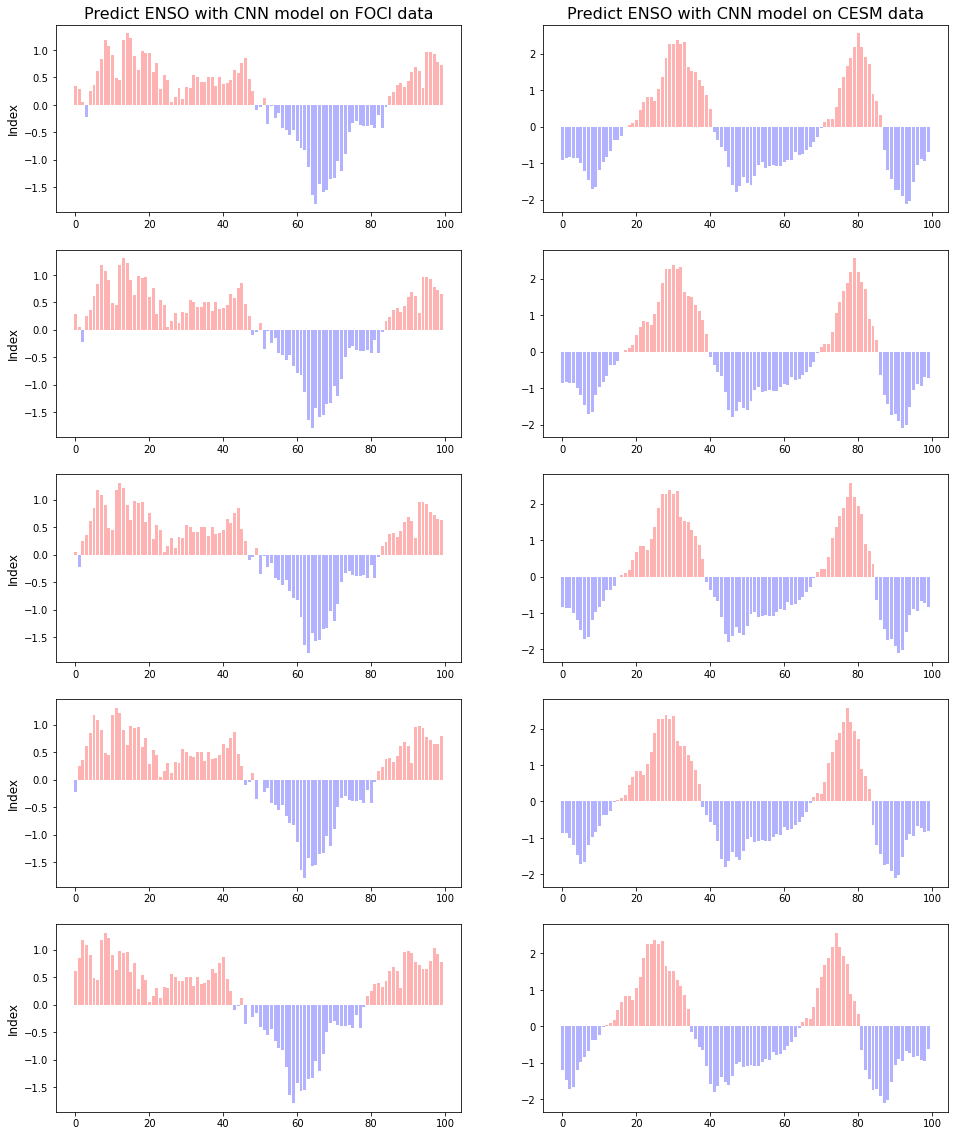

In [11]:
## Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line

# Plot first 500 time steps only:
fig, axes = plt.subplots(5,2,figsize=[16,20])

# Add titles:
axes[0,0].set_title('Predict ENSO with CNN model on FOCI data', fontsize=16)
axes[0,1].set_title('Predict ENSO with CNN model on CESM data', fontsize=16)

# Loop over predictions:
for i in range(len(val_pred_CNNfc_FOCI)):

    # FOCI
    axes[i,0].bar(
        x=range(len(val_target_FOCI.values[:500,i])),
        height=val_target_FOCI.values[:500,i],
        color=bar_color(val_target_FOCI[:500],'r','b')[i],
        label="true targets",
        alpha=0.3
    )
    axes[i,0].plot(val_pred_CNNfc_FOCI[i][:500,0], label="model predictions on validation data", color='black')
#   axes[i,0].legend()
    axes[i,0].set_ylabel('Index', fontsize=12)

    # CESM
    axes[i,1].bar(
        x=range(len(val_target_CESM.values[:500,i])),
        height=val_target_CESM.values[:500,i],
        color=bar_color(val_target_CESM[:500],'r','b')[i],
        label="true targets",
        alpha=0.3
    )
    axes[i,1].plot(val_pred_CNNfc_CESM[i][:500,0], label="model predictions on validation data", color='black')
#   axes[i,1].legend()

axes[len(val_pred_CNNfc_FOCI)-1,0].set_xlabel('Time [month]', fontsize=12)
axes[len(val_pred_CNNfc_FOCI)-1,1].set_xlabel('Time [month]', fontsize=12)

### Discussion on single-run experiments with ALL target horizons with CNN/fc model:

See higher frequency of ENSO events in CESM data: El Nino every 3-4 years.
Find higher loss (mse) but better correlation for CESM, compared to FOCI, for all target horizons.

### CNN / fc: Evaluation (part 2)

Define events from **consecutive masking**: El Nino and La Nina refer to index values greater or equal to 0.5 and lower or equal -0.5, respectively. Choose minimum event length to be 3 months to smooth fluctuations.

Show **contingency table**, including El Nino, La Nina and neutral state.

In [21]:
## Get El Nino and La Nina events with consecutive masking as boolean masks.
## Then convert to event table: 1=El Nino, -1=La Nina, 0=neutral

# FOCI targets:
train_target_FOCI_ElNino = el_nino(train_target_FOCI.values, threshold=0.5, min_event_length=3)
train_target_FOCI_LaNina = la_nina(train_target_FOCI.values, threshold=-0.5, min_event_length=3)
train_target_FOCI_event = train_target_FOCI_ElNino.astype(int) - train_target_FOCI_LaNina.astype(int)
val_target_FOCI_ElNino = el_nino(val_target_FOCI.values, threshold=0.5, min_event_length=3)
val_target_FOCI_LaNina = la_nina(val_target_FOCI.values, threshold=-0.5, min_event_length=3)
val_target_FOCI_event = val_target_FOCI_ElNino.astype(int) - val_target_FOCI_LaNina.astype(int)

# FOCI predictions with CNN/fc model: Convert to np.array.
train_pred_CNNfc_FOCI_ElNino = el_nino(np.array(train_pred_CNNfc_FOCI), axis=1, threshold=0.5, min_event_length=3)
train_pred_CNNfc_FOCI_LaNina = la_nina(np.array(train_pred_CNNfc_FOCI), axis=1, threshold=-0.5, min_event_length=3)
train_pred_CNNfc_FOCI_event = train_pred_CNNfc_FOCI_ElNino.astype(int) - train_pred_CNNfc_FOCI_LaNina.astype(int)
val_pred_CNNfc_FOCI_ElNino = el_nino(np.array(val_pred_CNNfc_FOCI), axis=1, threshold=0.5, min_event_length=3)
val_pred_CNNfc_FOCI_LaNina = la_nina(np.array(val_pred_CNNfc_FOCI), axis=1, threshold=-0.5, min_event_length=3)
val_pred_CNNfc_FOCI_event = val_pred_CNNfc_FOCI_ElNino.astype(int) - val_pred_CNNfc_FOCI_LaNina.astype(int)

# CESM targets:
train_target_CESM_ElNino = el_nino(train_target_CESM.values, threshold=0.5, min_event_length=3)
train_target_CESM_LaNina = la_nina(train_target_CESM.values, threshold=-0.5, min_event_length=3)
train_target_CESM_event = train_target_CESM_ElNino.astype(int) - train_target_CESM_LaNina.astype(int)
val_target_CESM_ElNino = el_nino(val_target_CESM.values, threshold=0.5, min_event_length=3)
val_target_CESM_LaNina = la_nina(val_target_CESM.values, threshold=-0.5, min_event_length=3)
val_target_CESM_event = val_target_CESM_ElNino.astype(int) - val_target_CESM_LaNina.astype(int)

# CESM predictions with CNN/fc model: Convert to np.array.
train_pred_CNNfc_CESM_ElNino = el_nino(np.array(train_pred_CNNfc_CESM), axis=1, threshold=0.5, min_event_length=3)
train_pred_CNNfc_CESM_LaNina = la_nina(np.array(train_pred_CNNfc_CESM), axis=1, threshold=-0.5, min_event_length=3)
train_pred_CNNfc_CESM_event = train_pred_CNNfc_CESM_ElNino.astype(int) - train_pred_CNNfc_CESM_LaNina.astype(int)
val_pred_CNNfc_CESM_ElNino = el_nino(np.array(val_pred_CNNfc_CESM), axis=1, threshold=0.5, min_event_length=3)
val_pred_CNNfc_CESM_LaNina = la_nina(np.array(val_pred_CNNfc_CESM), axis=1, threshold=-0.5, min_event_length=3)
val_pred_CNNfc_CESM_event = val_pred_CNNfc_CESM_ElNino.astype(int) - val_pred_CNNfc_CESM_LaNina.astype(int)

In [22]:
# Define events and corresponding values:
events=['El Nino','neutral','La Nina']
events_val=[1,0,-1]

# Initialize contingency tables, dimensions (#targets, #events, #events):
contingency_CNNfc_FOCI_train = np.zeros((len(train_pred_CNNfc_FOCI),3,3))
contingency_CNNfc_FOCI_val = np.zeros((len(val_pred_CNNfc_FOCI),3,3))
contingency_CNNfc_CESM_train = np.zeros((len(train_pred_CNNfc_CESM),3,3))
contingency_CNNfc_CESM_val = np.zeros((len(val_pred_CNNfc_CESM),3,3))

# Loop over target horizons:
for i in range(len(train_pred_CNNfc_FOCI)):

    # Loop over events in true targets:
    for j in range(len(events)):

        # Get true event value:
        true_value = events_val[j]

        # Loop over events in predictions:
        for k in range(len(events)):

            # Get predicted event value:
            pred_value = events_val[k]

            # Compute correctly predicted events and store in contingency table:
            contingency_CNNfc_FOCI_train[i,j,k] = np.sum((train_target_FOCI_event[:,i]==true_value) & (train_pred_CNNfc_FOCI_event[i,:,0]==pred_value))
            contingency_CNNfc_FOCI_val[i,j,k] = np.sum((val_target_FOCI_event[:,i]==true_value) & (val_pred_CNNfc_FOCI_event[i,:,0]==pred_value))
            contingency_CNNfc_CESM_train[i,j,k] = np.sum((train_target_CESM_event[:,i]==true_value) & (train_pred_CNNfc_CESM_event[i,:,0]==pred_value))
            contingency_CNNfc_CESM_val[i,j,k] = np.sum((val_target_CESM_event[:,i]==true_value) & (val_pred_CNNfc_CESM_event[i,:,0]==pred_value))
            
# Convert contingency table to integer values, for convenience:
contingency_CNNfc_FOCI_train = contingency_CNNfc_FOCI_train.astype(int)
contingency_CNNfc_FOCI_val = contingency_CNNfc_FOCI_val.astype(int)
contingency_CNNfc_CESM_train = contingency_CNNfc_CESM_train.astype(int)
contingency_CNNfc_CESM_val = contingency_CNNfc_CESM_val.astype(int)

In [23]:
## Now compute contingency table with RELATIVE values:
## E.g., for true El Nino, giving the relative amounts of predicted events.

## FOCI:

# Sum over predicted events, and stack:
contingency_CNNfc_FOCI_train_sum = np.stack([
    np.sum(contingency_CNNfc_FOCI_train, axis=-1),
    np.sum(contingency_CNNfc_FOCI_train, axis=-1),
    np.sum(contingency_CNNfc_FOCI_train, axis=-1)], axis=-1)
contingency_CNNfc_FOCI_val_sum = np.stack([
    np.sum(contingency_CNNfc_FOCI_val, axis=-1),
    np.sum(contingency_CNNfc_FOCI_val, axis=-1),
    np.sum(contingency_CNNfc_FOCI_val, axis=-1)], axis=-1)

# Compute relative contingency table: Divide ABSOLUTE values by summed values:
contingency_CNNfc_FOCI_train_rel = np.round(contingency_CNNfc_FOCI_train / contingency_CNNfc_FOCI_train_sum * 100,1)
contingency_CNNfc_FOCI_val_rel = np.round(contingency_CNNfc_FOCI_val / contingency_CNNfc_FOCI_val_sum * 100,1)

## CESM:

# Sum over predicted events, and stack:
contingency_CNNfc_CESM_train_sum = np.stack([
    np.sum(contingency_CNNfc_CESM_train, axis=-1),
    np.sum(contingency_CNNfc_CESM_train, axis=-1),
    np.sum(contingency_CNNfc_CESM_train, axis=-1)], axis=-1)
contingency_CNNfc_CESM_val_sum = np.stack([
    np.sum(contingency_CNNfc_CESM_val, axis=-1),
    np.sum(contingency_CNNfc_CESM_val, axis=-1),
    np.sum(contingency_CNNfc_CESM_val, axis=-1)], axis=-1)

# Compute relative contingency table: Divide ABSOLUTE values by summed values:
contingency_CNNfc_CESM_train_rel = np.round(contingency_CNNfc_CESM_train / contingency_CNNfc_CESM_train_sum * 100,1)
contingency_CNNfc_CESM_val_rel = np.round(contingency_CNNfc_CESM_val / contingency_CNNfc_CESM_val_sum * 100,1)

In [24]:
## Show contingency tables with ABSOLUT and RELATIVE values for various target horizons:

# Loop over target horizons:
for i in range(len(train_pred_CNNfc_FOCI)):
    print('Target: ',train_target_FOCI.columns[i])
    print('======================\n')
    
    # FOCI
    print('CNN: FOCI   Pred event:\n','          ',events,'\n')
    print('True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)')
    
    # Loop over true events:
    for j in range(len(events)):
        print(events[j],
              '   ',contingency_CNNfc_FOCI_train[i,j,:], ' ',contingency_CNNfc_FOCI_train_rel[i,j,:],
              '   ',contingency_CNNfc_FOCI_val[i,j,:], ' ',contingency_CNNfc_FOCI_val_rel[i,j,:])
    print('\n')

    # CESM
    print('CNN: CESM   Pred event:\n','          ',events,'\n')
    print('True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)')
    
    # Loop over true events:
    for j in range(len(events)):
        print(events[j],
              '   ',contingency_CNNfc_CESM_train[i,j,:], ' ',contingency_CNNfc_CESM_train_rel[i,j,:],
              '   ',contingency_CNNfc_CESM_val[i,j,:], ' ',contingency_CNNfc_CESM_val_rel[i,j,:])
    print('\n\n')

Target:  ENSO_34

CNN: FOCI   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)
El Nino     [1386  582    0]   [70.4 29.6  0. ]     [338 234   0]   [59.1 40.9  0. ]
neutral     [ 369 4493  494]   [ 6.9 83.9  9.2]     [ 101 1024  121]   [ 8.1 82.2  9.7]
La Nina     [   3  893 1356]   [ 0.1 39.7 60.2]     [  3 216 358]   [ 0.5 37.4 62. ]


CNN: CESM   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)
El Nino     [1799  693    7]   [72.  27.7  0.3]     [470 170   5]   [72.9 26.4  0.8]
neutral     [ 396 3592  325]   [ 9.2 83.3  7.5]     [138 798  61]   [13.8 80.   6.1]
La Nina     [   6  911 1847]   [ 0.2 33.  66.8]     [  4 271 466]   [ 0.5 36.6 62.9]



Target:  ENSO_34_lead1

CNN: FOCI   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           

### Discussion on CNN contingency tables

Find significantly higher number of El Nino and La Nina events in CESM data, compared to FOCI.
Prediction accuracy seems to be higher for CESM, in terms of correctly predicted events.

### LSTM / fc: Define model parameters and start single-run experiment on ALL target horizons

**Note:** Normalize inputs in data pre-processing!

In [33]:
# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
LSTM_units = [10,20]
fc_units = [20,10]
fc_hidden_activation = 'linear'
n_epochs = 15
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

In [34]:
## Set up compiled LSTM/fc models separately for both - FOCI and CESM, and ALL target horizons:

# Initialize storages for models:
models_LSTMfc_FOCI = []
models_LSTMfc_CESM = []

# Set model for ALL target horizons:
for i in range(len(target_FOCI.columns)):
    temp_model_FOCI = set_LSTM_fc(LSTM_units, fc_units, fc_hidden_activation,
                                 n_epochs, batch_size, learning_rate, loss_function)
    temp_model_CESM = set_LSTM_fc(LSTM_units, fc_units, fc_hidden_activation,
                                 n_epochs, batch_size, learning_rate, loss_function)
    # Store models:
    models_LSTMfc_FOCI.append(temp_model_FOCI)
    models_LSTMfc_CESM.append(temp_model_CESM)    

# Show model summary for one model, as example:
models_LSTMfc_FOCI[0].summary()
#plot_model(models_LSTMfc_FOCI[0], show_shapes=True, show_layer_names=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 10)            1440      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 4,561
Trainable params: 4,561
Non-trainable params: 0
_________________________________________________________________


In [257]:
## Train all models and store histories:

# Initialize storages for histories:
histories_LSTMfc_FOCI = []
histories_LSTMfc_CESM = []

# FOCI models:
for i in range(len(models_LSTMfc_FOCI)):
    
    # Print status:
    print("FOCI model:", i+1, "of", len(models_LSTMfc_FOCI))
    temp_history = models_LSTMfc_FOCI[i].fit(train_input_scaled_FOCI, train_target_FOCI.iloc[:,[i]].values,
                                            epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=0,
                                            validation_data=(
                                                val_input_scaled_FOCI,
                                                val_target_FOCI.iloc[:,[i]].values
                                            ))
    
    # Store history:
    histories_LSTMfc_FOCI.append(temp_history)
    
# CESM models:
for i in range(len(models_LSTMfc_CESM)):
    
    # Print status:
    print("CESM model:", i+1, "of", len(models_LSTMfc_CESM))
    temp_history = models_LSTMfc_CESM[i].fit(train_input_scaled_CESM, train_target_CESM.iloc[:,[i]].values,
                                            epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=0,
                                            validation_data=(
                                                val_input_scaled_CESM,
                                                val_target_CESM.iloc[:,[i]].values
                                                 ))
    
    # Store history:
    histories_LSTMfc_CESM.append(temp_history)

FOCI model: 1 of 5
FOCI model: 2 of 5
FOCI model: 3 of 5
FOCI model: 4 of 5
FOCI model: 5 of 5
CESM model: 1 of 5
CESM model: 2 of 5
CESM model: 3 of 5
CESM model: 4 of 5
CESM model: 5 of 5


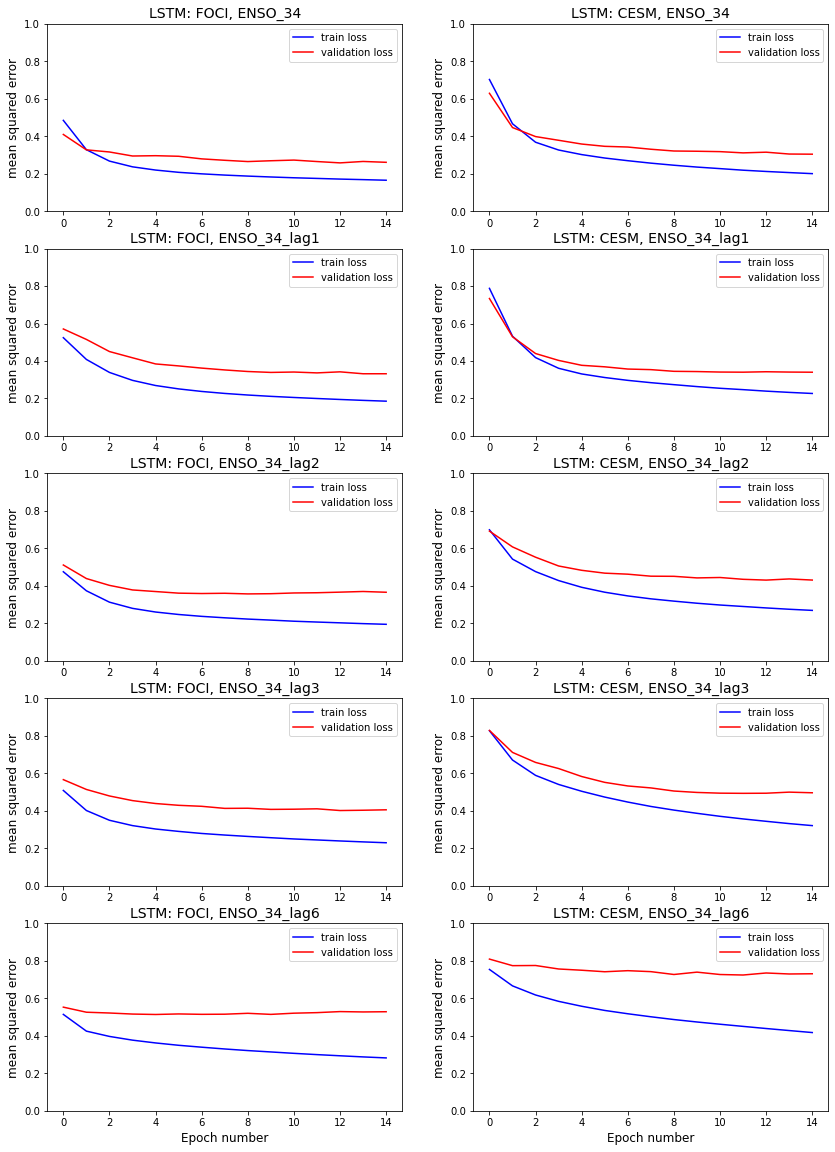

In [261]:
# Plot train and val_loss (mse), for both models and ALL target horizons:
fig, axes = plt.subplots(5, 2, figsize=(14,20))

# Loop over target horizons:
for i in range(len(histories_LSTMfc_FOCI)):

    # FOCI
    axes[i,0].plot(histories_LSTMfc_FOCI[i].history['loss'], color = 'blue', label = 'train loss')
    axes[i,0].plot(histories_LSTMfc_FOCI[i].history['val_loss'], color = 'red', label = 'validation loss')
    axes[i,0].set_ylabel('mean squared error', fontsize=12)
    axes[i,0].set_ylim([0,1])
    axes[i,0].set_title('LSTM: FOCI, '+target_FOCI.columns[i], fontsize=14)
    axes[i,0].legend()

    # CESM
    axes[i,1].plot(histories_LSTMfc_CESM[i].history['loss'], color = 'blue', label = 'train loss')
    axes[i,1].plot(histories_LSTMfc_CESM[i].history['val_loss'], color = 'red', label = 'validation loss')
    axes[i,1].set_ylabel('mean squared error', fontsize=12)
    axes[i,1].set_ylim([0,1])
    axes[i,1].set_title('LSTM: CESM, '+target_CESM.columns[i], fontsize=14)
    axes[i,1].legend()

axes[len(histories_LSTMfc_FOCI)-1,0].set_xlabel('Epoch number', fontsize=12)
axes[len(histories_LSTMfc_FOCI)-1,1].set_xlabel('Epoch number', fontsize=12)

plt.show()

In [26]:
## Save and re-load trained LSTM/fc models:


# ## Saved models for LSTM experiments on FOCI and CESM inputs and ENSO3.4 as target with various time leads.
# models_LSTMfc_FOCI[0].save('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead0')
# models_LSTMfc_FOCI[1].save('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead1')
# models_LSTMfc_FOCI[2].save('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead2')
# models_LSTMfc_FOCI[3].save('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead3')
# models_LSTMfc_FOCI[4].save('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead6')
# models_LSTMfc_CESM[0].save('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead0')
# models_LSTMfc_CESM[1].save('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead1')
# models_LSTMfc_CESM[2].save('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead2')
# models_LSTMfc_CESM[3].save('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead3')
# models_LSTMfc_CESM[4].save('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead6')


# ## Reload trained LSTM models:

# !!!!! Normalize inputs in data pre-processing !!!!!

# # Initialize storages for models:
# models_LSTMfc_FOCI = []
# models_LSTMfc_CESM = []

# models_LSTMfc_FOCI_ENSO_lead0 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead0')
# models_LSTMfc_FOCI_ENSO_lead1 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead1')
# models_LSTMfc_FOCI_ENSO_lead2 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead2')
# models_LSTMfc_FOCI_ENSO_lead3 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead3')
# models_LSTMfc_FOCI_ENSO_lead6 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_FOCI_ENSO_lead6')

# models_LSTMfc_FOCI.append(models_LSTMfc_FOCI_ENSO_lead0)
# models_LSTMfc_FOCI.append(models_LSTMfc_FOCI_ENSO_lead1)
# models_LSTMfc_FOCI.append(models_LSTMfc_FOCI_ENSO_lead2)
# models_LSTMfc_FOCI.append(models_LSTMfc_FOCI_ENSO_lead3)
# models_LSTMfc_FOCI.append(models_LSTMfc_FOCI_ENSO_lead6)

# models_LSTMfc_CESM_ENSO_lead0 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead0')
# models_LSTMfc_CESM_ENSO_lead1 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead1')
# models_LSTMfc_CESM_ENSO_lead2 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead2')
# models_LSTMfc_CESM_ENSO_lead3 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead3')
# models_LSTMfc_CESM_ENSO_lead6 = tf.keras.models.load_model('../models/LSTM_final/models_LSTMfc_CESM_ENSO_lead6')

# models_LSTMfc_CESM.append(models_LSTMfc_CESM_ENSO_lead0)
# models_LSTMfc_CESM.append(models_LSTMfc_CESM_ENSO_lead1)
# models_LSTMfc_CESM.append(models_LSTMfc_CESM_ENSO_lead2)
# models_LSTMfc_CESM.append(models_LSTMfc_CESM_ENSO_lead3)
# models_LSTMfc_CESM.append(models_LSTMfc_CESM_ENSO_lead6)

In [35]:
## Get predictions for both models and ALL target horizons:

# Initialize storages:
train_pred_LSTMfc_FOCI = []
val_pred_LSTMfc_FOCI = []
train_pred_LSTMfc_CESM = []
val_pred_LSTMfc_CESM = []

# FOCI models:
for i in range(len(models_LSTMfc_FOCI)):   

    train_pred_LSTMfc_FOCI.append(models_LSTMfc_FOCI[i](train_input_scaled_FOCI))
    val_pred_LSTMfc_FOCI.append(models_LSTMfc_FOCI[i](val_input_scaled_FOCI))
    
# CESM models:
for i in range(len(models_LSTMfc_CESM)):   

    train_pred_LSTMfc_CESM.append(models_LSTMfc_CESM[i](train_input_scaled_CESM))
    val_pred_LSTMfc_CESM.append(models_LSTMfc_CESM[i](val_input_scaled_CESM))

### LSTM / fc: Evaluation (part 1)

- Compute **mean squared error (mse)** used as loss function between model predictions and true targets, separately for training and validation data. 
- Show **correlation** of predictions and targets as additional metric.

In [36]:
## Check loss (mse) and correlation of true targets vs. model predictions:

# FOCI
print("CNN: FOCI\n====")
print("Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_CNNfc_FOCI[i][:,0] - train_target_FOCI.values[:,i])**2),3) 
 for i in range(len(train_pred_CNNfc_FOCI))])
print("Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_CNNfc_FOCI[i][:,0] - val_target_FOCI.values[:,i])**2),3) 
 for i in range(len(val_pred_CNNfc_FOCI))])
print("Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_CNNfc_FOCI[i][:,0], train_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_CNNfc_FOCI))])
print("Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_CNNfc_FOCI[i][:,0], val_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_CNNfc_FOCI))])

print("\nLSTM: FOCI\n====")
print("Loss (mse) on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_LSTMfc_FOCI[i][:,0] - train_target_FOCI.values[:,i])**2),3) 
 for i in range(len(train_pred_LSTMfc_FOCI))])
print("Loss (mse) on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_LSTMfc_FOCI[i][:,0] - val_target_FOCI.values[:,i])**2),3) 
 for i in range(len(val_pred_LSTMfc_FOCI))])
print("Corr.Coeff on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_LSTMfc_FOCI[i][:,0], train_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_LSTMfc_FOCI))])
print("Corr.Coeff on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_LSTMfc_FOCI[i][:,0], val_target_FOCI.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_LSTMfc_FOCI))])

# CESM
print("\nCNN: CESM\n====")
print("Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_CNNfc_CESM[i][:,0] - train_target_CESM.values[:,i])**2),3) 
 for i in range(len(train_pred_CNNfc_CESM))])
print("Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_CNNfc_CESM[i][:,0] - val_target_CESM.values[:,i])**2),3) 
 for i in range(len(val_pred_CNNfc_CESM))])
print("Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_CNNfc_CESM[i][:,0], train_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_CNNfc_CESM))])
print("Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_CNNfc_CESM[i][:,0], val_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_CNNfc_CESM))])

print("\nLSTM: CESM\n====")
print("Loss (mse) on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((train_pred_LSTMfc_CESM[i][:,0] - train_target_CESM.values[:,i])**2),3) 
 for i in range(len(train_pred_LSTMfc_CESM))])
print("Loss (mse) on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.mean((val_pred_LSTMfc_CESM[i][:,0] - val_target_CESM.values[:,i])**2),3) 
 for i in range(len(val_pred_LSTMfc_CESM))])
print("Corr.Coeff on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([train_pred_LSTMfc_CESM[i][:,0], train_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(train_pred_LSTMfc_CESM))])
print("Corr.Coeff on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]:", 
      [np.round(np.corrcoef(np.stack([val_pred_LSTMfc_CESM[i][:,0], val_target_CESM.values[:,i]]))[0,1],3)
 for i in range(len(val_pred_LSTMfc_CESM))])

CNN: FOCI
====
Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.159, 0.17, 0.21, 0.214, 0.273]
Loss (mse) on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.235, 0.251, 0.293, 0.365, 0.468]
Corr.Coeff on TRAIN data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.844, 0.833, 0.792, 0.785, 0.715]
Corr.Coeff on  VAL  data with CNN / fc [lead0, lead1, lead2, lead3, lead6]: [0.808, 0.795, 0.751, 0.677, 0.56]

LSTM: FOCI
====
Loss (mse) on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]: [0.162, 0.183, 0.192, 0.226, 0.278]
Loss (mse) on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]: [0.26, 0.332, 0.366, 0.406, 0.529]
Corr.Coeff on TRAIN data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]: [0.841, 0.818, 0.808, 0.769, 0.706]
Corr.Coeff on  VAL  data with LSTM / fc [lead0, lead1, lead2, lead3, lead6]: [0.787, 0.718, 0.685, 0.639, 0.473]

CNN: CESM
====
Loss (mse) on TRAIN data with CNN / fc [lead0, lead1, le

In [37]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0.5, 0, 'Time [month]')

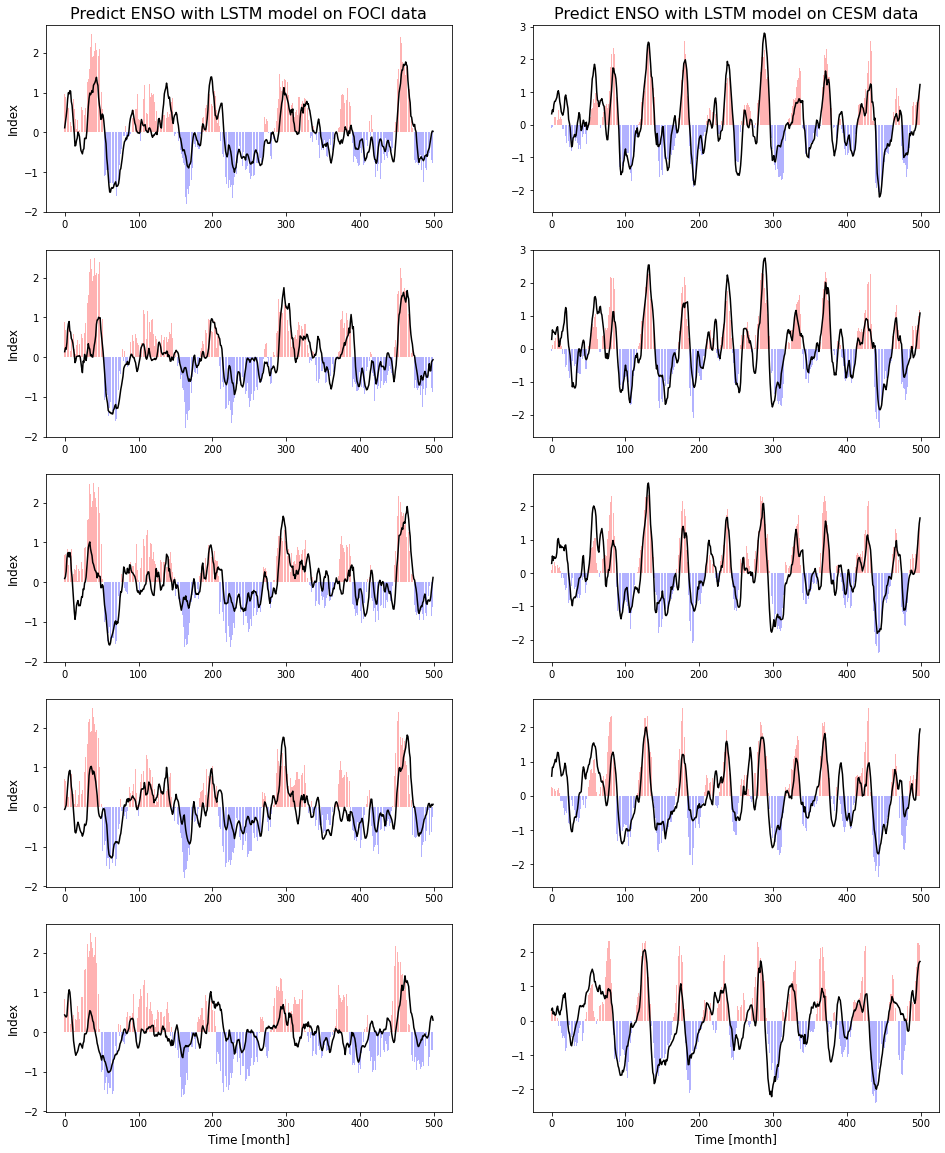

In [38]:
## Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line

# Plot first 500 time steps only:
fig, axes = plt.subplots(5,2,figsize=[16,20])

# Add titles:
axes[0,0].set_title('Predict ENSO with LSTM model on FOCI data', fontsize=16)
axes[0,1].set_title('Predict ENSO with LSTM model on CESM data', fontsize=16)

# Loop over predictions:
for i in range(len(val_pred_LSTMfc_FOCI)):

    # FOCI
    axes[i,0].bar(
        x=range(len(val_target_FOCI.values[:500,i])),
        height=val_target_FOCI.values[:500,i],
        color=bar_color(val_target_FOCI[:500],'r','b')[i],
        label="true targets",
        alpha=0.3
    )
    axes[i,0].plot(val_pred_LSTMfc_FOCI[i][:500,0], label="model predictions on validation data", color='black')
#   axes[i,0].legend()
    axes[i,0].set_ylabel('Index', fontsize=12)

    # CESM
    axes[i,1].bar(
        x=range(len(val_target_CESM.values[:500,i])),
        height=val_target_CESM.values[:500,i],
        color=bar_color(val_target_CESM[:500],'r','b')[i],
        label="true targets",
        alpha=0.3
    )
    axes[i,1].plot(val_pred_LSTMfc_CESM[i][:500,0], label="model predictions on validation data", color='black')
#   axes[i,1].legend()

axes[len(val_pred_LSTMfc_FOCI)-1,0].set_xlabel('Time [month]', fontsize=12)
axes[len(val_pred_LSTMfc_FOCI)-1,1].set_xlabel('Time [month]', fontsize=12)

### Discussion on single-run experiments with ALL target horizons with LSTM/fc model:

See higher frequency of ENSO events in CESM data: El Nino every 3-4 years.
Find higher loss (mse) but better correlation for FOCI, compared to CESM, as for CNN/fc model.

### LSTM / fc: Evaluation (part 2)

Define events from **consecutive masking**: El Nino and La Nina refer to index values greater or equal to 0.5 and lower or equal -0.5, respectively. Choose minimum event length to be 3 months.

Show **contingency table**, including El Nino, La Nina and neutral state.

In [39]:
## Get El Nino and La Nina events with consecutive masking as boolean masks.
## Then convert to event table: 1=El Nino, -1=La Nina, 0=neutral

# FOCI targets:
train_target_FOCI_ElNino = el_nino(train_target_FOCI.values, threshold=0.5, min_event_length=3)
train_target_FOCI_LaNina = la_nina(train_target_FOCI.values, threshold=-0.5, min_event_length=3)
train_target_FOCI_event = train_target_FOCI_ElNino.astype(int) - train_target_FOCI_LaNina.astype(int)
val_target_FOCI_ElNino = el_nino(val_target_FOCI.values, threshold=0.5, min_event_length=3)
val_target_FOCI_LaNina = la_nina(val_target_FOCI.values, threshold=-0.5, min_event_length=3)
val_target_FOCI_event = val_target_FOCI_ElNino.astype(int) - val_target_FOCI_LaNina.astype(int)

# FOCI predictions with CNN/fc model: Convert to np.array.
train_pred_LSTMfc_FOCI_ElNino = el_nino(np.array(train_pred_LSTMfc_FOCI), axis=1, threshold=0.5, min_event_length=3)
train_pred_LSTMfc_FOCI_LaNina = la_nina(np.array(train_pred_LSTMfc_FOCI), axis=1, threshold=-0.5, min_event_length=3)
train_pred_LSTMfc_FOCI_event = train_pred_LSTMfc_FOCI_ElNino.astype(int) - train_pred_LSTMfc_FOCI_LaNina.astype(int)
val_pred_LSTMfc_FOCI_ElNino = el_nino(np.array(val_pred_LSTMfc_FOCI), axis=1, threshold=0.5, min_event_length=3)
val_pred_LSTMfc_FOCI_LaNina = la_nina(np.array(val_pred_LSTMfc_FOCI), axis=1, threshold=-0.5, min_event_length=3)
val_pred_LSTMfc_FOCI_event = val_pred_LSTMfc_FOCI_ElNino.astype(int) - val_pred_LSTMfc_FOCI_LaNina.astype(int)

# CESM targets:
train_target_CESM_ElNino = el_nino(train_target_CESM.values, threshold=0.5, min_event_length=3)
train_target_CESM_LaNina = la_nina(train_target_CESM.values, threshold=-0.5, min_event_length=3)
train_target_CESM_event = train_target_CESM_ElNino.astype(int) - train_target_CESM_LaNina.astype(int)
val_target_CESM_ElNino = el_nino(val_target_CESM.values, threshold=0.5, min_event_length=3)
val_target_CESM_LaNina = la_nina(val_target_CESM.values, threshold=-0.5, min_event_length=3)
val_target_CESM_event = val_target_CESM_ElNino.astype(int) - val_target_CESM_LaNina.astype(int)

# CESM predictions with CNN/fc model: Convert to np.array.
train_pred_LSTMfc_CESM_ElNino = el_nino(np.array(train_pred_LSTMfc_CESM), axis=1, threshold=0.5, min_event_length=3)
train_pred_LSTMfc_CESM_LaNina = la_nina(np.array(train_pred_LSTMfc_CESM), axis=1, threshold=-0.5, min_event_length=3)
train_pred_LSTMfc_CESM_event = train_pred_LSTMfc_CESM_ElNino.astype(int) - train_pred_LSTMfc_CESM_LaNina.astype(int)
val_pred_LSTMfc_CESM_ElNino = el_nino(np.array(val_pred_LSTMfc_CESM), axis=1, threshold=0.5, min_event_length=3)
val_pred_LSTMfc_CESM_LaNina = la_nina(np.array(val_pred_LSTMfc_CESM), axis=1, threshold=-0.5, min_event_length=3)
val_pred_LSTMfc_CESM_event = val_pred_LSTMfc_CESM_ElNino.astype(int) - val_pred_LSTMfc_CESM_LaNina.astype(int)

In [40]:
# Define events and corresponding values:
events=['El Nino','neutral','La Nina']
events_val=[1,0,-1]

# Initialize contingency tables, dimensions (#targets, #events, #events):
contingency_LSTMfc_FOCI_train = np.zeros((len(train_pred_LSTMfc_FOCI),3,3))
contingency_LSTMfc_FOCI_val = np.zeros((len(val_pred_LSTMfc_FOCI),3,3))
contingency_LSTMfc_CESM_train = np.zeros((len(train_pred_LSTMfc_CESM),3,3))
contingency_LSTMfc_CESM_val = np.zeros((len(val_pred_LSTMfc_CESM),3,3))

# Loop over target horizons:
for i in range(len(train_pred_LSTMfc_FOCI)):

    # Loop over events in true targets:
    for j in range(len(events)):

        # Get true event value:
        true_value = events_val[j]

        # Loop over events in predictions:
        for k in range(len(events)):

            # Get predicted event value:
            pred_value = events_val[k]

            # Compute correctly predicted events and store in contingency table:
            contingency_LSTMfc_FOCI_train[i,j,k] = np.sum((train_target_FOCI_event[:,i]==true_value) & (train_pred_LSTMfc_FOCI_event[i,:,0]==pred_value))
            contingency_LSTMfc_FOCI_val[i,j,k] = np.sum((val_target_FOCI_event[:,i]==true_value) & (val_pred_LSTMfc_FOCI_event[i,:,0]==pred_value))
            contingency_LSTMfc_CESM_train[i,j,k] = np.sum((train_target_CESM_event[:,i]==true_value) & (train_pred_LSTMfc_CESM_event[i,:,0]==pred_value))
            contingency_LSTMfc_CESM_val[i,j,k] = np.sum((val_target_CESM_event[:,i]==true_value) & (val_pred_LSTMfc_CESM_event[i,:,0]==pred_value))
            
# Convert contingency table to integer values, for convenience:
contingency_LSTMfc_FOCI_train = contingency_LSTMfc_FOCI_train.astype(int)
contingency_LSTMfc_FOCI_val = contingency_LSTMfc_FOCI_val.astype(int)
contingency_LSTMfc_CESM_train = contingency_LSTMfc_CESM_train.astype(int)
contingency_LSTMfc_CESM_val = contingency_LSTMfc_CESM_val.astype(int)

In [41]:
## Now compute contingency table with RELATIVE values:
## E.g., for true El Nino, giving the relative amounts of predicted events.

## FOCI:

# Sum over predicted events, and stack:
contingency_LSTMfc_FOCI_train_sum = np.stack([
    np.sum(contingency_LSTMfc_FOCI_train, axis=-1),
    np.sum(contingency_LSTMfc_FOCI_train, axis=-1),
    np.sum(contingency_LSTMfc_FOCI_train, axis=-1)], axis=-1)
contingency_LSTMfc_FOCI_val_sum = np.stack([
    np.sum(contingency_LSTMfc_FOCI_val, axis=-1),
    np.sum(contingency_LSTMfc_FOCI_val, axis=-1),
    np.sum(contingency_LSTMfc_FOCI_val, axis=-1)], axis=-1)

# Compute relative contingency table: Divide ABSOLUTE values by summed values:
contingency_LSTMfc_FOCI_train_rel = np.round(contingency_LSTMfc_FOCI_train / contingency_LSTMfc_FOCI_train_sum * 100,1)
contingency_LSTMfc_FOCI_val_rel = np.round(contingency_LSTMfc_FOCI_val / contingency_LSTMfc_FOCI_val_sum * 100,1)

## CESM:

# Sum over predicted events, and stack:
contingency_LSTMfc_CESM_train_sum = np.stack([
    np.sum(contingency_LSTMfc_CESM_train, axis=-1),
    np.sum(contingency_LSTMfc_CESM_train, axis=-1),
    np.sum(contingency_LSTMfc_CESM_train, axis=-1)], axis=-1)
contingency_LSTMfc_CESM_val_sum = np.stack([
    np.sum(contingency_LSTMfc_CESM_val, axis=-1),
    np.sum(contingency_LSTMfc_CESM_val, axis=-1),
    np.sum(contingency_LSTMfc_CESM_val, axis=-1)], axis=-1)

# Compute relative contingency table: Divide ABSOLUTE values by summed values:
contingency_LSTMfc_CESM_train_rel = np.round(contingency_LSTMfc_CESM_train / contingency_LSTMfc_CESM_train_sum * 100,1)
contingency_LSTMfc_CESM_val_rel = np.round(contingency_LSTMfc_CESM_val / contingency_LSTMfc_CESM_val_sum * 100,1)

In [42]:
## Show contingency tables with ABSOLUT and RELATIVE values for various target horizons:

# Loop over target horizons:
for i in range(len(train_pred_LSTMfc_FOCI)):
    print('Target: ',train_target_FOCI.columns[i])
    print('======================\n')
    
    # FOCI
    print('LSTM: FOCI   Pred event:\n','          ',events,'\n')
    print('True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)')
    
    # Loop over true events:
    for j in range(len(events)):
        print(events[j],
              '   ',contingency_LSTMfc_FOCI_train[i,j,:], ' ',contingency_LSTMfc_FOCI_train_rel[i,j,:],
              '   ',contingency_LSTMfc_FOCI_val[i,j,:], ' ',contingency_LSTMfc_FOCI_val_rel[i,j,:])
    print('\n')

    # CESM
    print('LSTM: CESM   Pred event:\n','          ',events,'\n')
    print('True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)')
    
    # Loop over true events:
    for j in range(len(events)):
        print(events[j],
              '   ',contingency_LSTMfc_CESM_train[i,j,:], ' ',contingency_LSTMfc_CESM_train_rel[i,j,:],
              '   ',contingency_LSTMfc_CESM_val[i,j,:], ' ',contingency_LSTMfc_CESM_val_rel[i,j,:])
    print('\n\n')

Target:  ENSO_34

LSTM: FOCI   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)
El Nino     [1387  581    0]   [70.5 29.5  0. ]     [319 250   3]   [55.8 43.7  0.5]
neutral     [ 420 4325  611]   [ 7.8 80.8 11.4]     [107 963 176]   [ 8.6 77.3 14.1]
La Nina     [   3  852 1397]   [ 0.1 37.8 62. ]     [  2 206 369]   [ 0.3 35.7 64. ]


LSTM: CESM   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           VAL (abs)       VAL (rel %)
El Nino     [1894  605    0]   [75.8 24.2  0. ]     [446 191   8]   [69.1 29.6  1.2]
neutral     [ 489 3370  454]   [11.3 78.1 10.5]     [142 747 108]   [14.2 74.9 10.8]
La Nina     [   9  726 2029]   [ 0.3 26.3 73.4]     [  3 253 485]   [ 0.4 34.1 65.5]



Target:  ENSO_34_lead1

LSTM: FOCI   Pred event:
            ['El Nino', 'neutral', 'La Nina'] 

True event:  TRAIN (abs)        TRAIN (rel %)           

### Discussion on LSTM contingency tables

LSTM/fc model seems to be better in correctly predicting La Nina events, whereas CNN/fc model shows better performance on El Nino events.